# Equalizador Não Linear para um Sistema de Comunicações Ópticos Utilizando Redes Neurais

In [1]:
import numpy as np
from commpy.utilities  import upsample
from optic.models.devices import mzm, photodiode, edfa
from optic.models.channels import linearFiberChannel
from optic.comm.modulation import GrayMapping, modulateGray, demodulateGray
from optic.comm.metrics import  theoryBER
from optic.dsp.core import pulseShape, lowPassFIR, pnorm, signal_power

try:
    from optic.dsp.coreGPU import firFilter    
except ImportError:
    from optic.dsp.core import firFilter
    
from optic.utils import parameters, dBm2W
from optic.plot import eyediagram, pconst
import matplotlib.pyplot as plt
from scipy.special import erfc
from tqdm.notebook import tqdm
import scipy as sp



In [2]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

figsize(5, 3)
plt.rcParams.update({'font.size': 11})

In [3]:
# %load_ext autoreload
# %autoreload 2

In [4]:
np.random.seed(seed=123)

# Funções para Simulação de Sistemas Ópticos

In [5]:
def SimulaSinalOptico(SpS, Rs, M, mod_format = 'pam', num_symbs = 1e6, pulse_format = 'nrz', MZM_Vpi = 2, Pi_dBm = 0, Pi_in = 0.5):
    
    Fs = SpS*Rs 
    Pi_W = dBm2W(Pi_dBm)
    
    paramMZM = parameters()
    paramMZM.Vpi = MZM_Vpi
    paramMZM.Vb = -paramMZM.Vpi/2
    
    bitsTx = np.random.randint(2, size = int(np.log2(M)*num_symbs))
    
    symbTx = modulateGray(bitsTx, M, mod_format)    
    symbTx = pnorm(symbTx) # normaliza a potência 
    
    symbUp = upsample(symbTx, SpS)
    
    pulse = pulseShape(pulse_format, SpS)
    pulse = pulse/max(abs(pulse))
    
    sigTx = firFilter(pulse, symbUp)
    
    
    Ai = np.sqrt(Pi_W)
    sigTxo = mzm(Ai, Pi_in*sigTx, paramMZM)
    
    return sigTxo, symbTx
def SimulaCanalOptico(sinal, SpS, Rs, dist_fibra, perda_fibra = 0.2, dispersao = 16, freq_central = 193.1e12, ruido = 4.5):
     
    Fs = SpS*Rs
    paramCh = parameters()
    paramCh.L = dist_fibra         # Distância [km]
    paramCh.α = perda_fibra        # Parâmetro de perdas da fibra [dB/km]
    paramCh.D = dispersao         # Parâmetro de dispersão da fibra [ps/nm/km]
    paramCh.Fc = freq_central  # Frequência óptica central [Hz]
    paramCh.Fs = Fs        # Frequência de amostragem da simulação [samples/second]
    
    sigCh = linearFiberChannel(sinal, paramCh)
    
    # Pré-amplificador do receptor
    paramEDFA = parameters()
    paramEDFA.G = paramCh.α*paramCh.L    # ganho edfa
    paramEDFA.NF = ruido   # edfa noise figure 
    paramEDFA.Fc = paramCh.Fc
    paramEDFA.Fs = Fs

    sigCh = edfa(sigCh, paramEDFA)
    
    paramPD = parameters()
    paramPD.ideal = False
    paramPD.B = Rs
    paramPD.Fs = Fs

    I_Rx = photodiode(sigCh, paramPD)
    
    return I_Rx

def RecuperaBits(sinal, SpS, M, mod_format = 'pam'):
    #Normaliza o sinal e seleciona os valores no intervalo de sinalização
    sinal = sinal/np.std(sinal)
    amostras = sinal[0::SpS]
    

    #Tira o nível DC e normaliza a potência
    amostras = amostras - amostras.mean()
    amostras = pnorm(amostras)
    

    # Demodula os símbolos para bits usando a mínima distância euclidiana 
    const = GrayMapping(M, mod_format) 
    Es = signal_power(const) 

    bits = demodulateGray(np.sqrt(Es)*amostras, M, mod_format)
    
    return bits

def CalculaBER(bits_transmitidos, bits_recebidos):
    discard = 100
    err = np.logical_xor(bits_recebidos[discard:bits_recebidos.size-discard], bits_transmitidos[discard:bits_transmitidos.size-discard])
    BER = np.mean(err)

    #Pb = 0.5*erfc(Q/np.sqrt(2)) # theoretical error probability
    print('Number of counted errors = %d '%(err.sum()))
    print('BER = %.2e '%(BER))
    #print('Pb = %.2e '%(Pb))

    err = err*1.0
    err[err==0] = np.nan

    plt.plot(err,'o', label = 'bit errors')
    plt.vlines(np.where(err>0), 0, 1)
    plt.xlabel('bit position')
    plt.ylabel('counted error')
    plt.legend()
    plt.grid()
    plt.ylim(0, 1.5)
    plt.xlim(0,err.size);

def CriaDataSet(symb,signal, SpS_in, train_pct = 0.8, Ntaps = 64, SpS_out = 1, batch_size = 64, shuffle = False):
    
    Nsymbols = len(symb)
    
    signal_full = pnorm(signal[0::SpS_in//SpS_out])   #Recupera o sinal nos intervalos de sinalização
    signal = pnorm(signal[0:Nsymbols*SpS_in:SpS_in//SpS_out])
    symbols = pnorm(symb[0:Nsymbols])   #Símbolos a serem passados como alvo do equalizador

    signal = (signal - np.mean(signal))/np.std(signal)
    signal_full = (signal_full - np.mean(signal_full))/np.std(signal_full)
    symbols = (symbols - np.mean(symbols))/np.std(symbols)
    
    symbols = symbols.reshape(-1,1)
    
    idx_train = np.arange(0, int(train_pct * len(symbols)))
    idx_eval = np.arange(int(train_pct * len(symbols)), len(symbols))

    sig_train = signal[idx_train] #80% para treinamento
    sig_test = signal[idx_eval]   #20% para avaliação do progresso
    sig_full = signal_full        #100% para teste
    
    train_dataset = slidingWindowDataSet(sig_train, symbols[idx_train], Ntaps, SpS_out)
    test_dataset = slidingWindowDataSet(sig_test, symbols[idx_eval], Ntaps, SpS_out)
    full_dataset = slidingWindowDataSet(signal_full, symbols, Ntaps, SpS_out)
    
    
    return train_dataset, test_dataset, full_dataset

In [6]:
help(linearFiberChannel)

Help on function linearFiberChannel in module optic.models.channels:

linearFiberChannel(Ei, param)
    Simulate signal propagation through a linear fiber channel.
    
    Parameters
    ----------
    Ei : np.array
        Input optical field.
    param : parameter object  (struct)
        Object with physical/simulation parameters of the optical channel.
    
        - param.L: total fiber length [km][default: 50 km]
    
        - param.alpha: fiber attenuation parameter [dB/km][default: 0.2 dB/km]
    
        - param.D: chromatic dispersion parameter [ps/nm/km][default: 16 ps/nm/km]
    
        - param.Fc: carrier frequency [Hz] [default: 193.1e12 Hz]
    
        - param.Fs: sampling frequency [Hz] [default: None]
    
        - param.returnParameters: bool, return channel parameters [default: False]
    
    Returns
    -------
    Eo : np.array
        Optical field at the output of the fiber.



Formato do array de bits:  (2000000,)
Formato do array dos bits modulados em PAM:  (1000000,)
Formato do array depois do upsampling  (16000000,)
Formato do array depois da formataç~~ao de pulso:  (16000000,)
Potência média do sinal ótpico modulado [mW]: 0.500 mW
Potência média do sinal óptico modualdo [dBm: -3.009 dBm]
Quantidade de bits:  2000000


"\n#Plot da PSD\naxs[0].set_xlim(-3*Rs, 3*Rs);\naxs[0].set_ylim(-180, -80);\naxs[0].psd(sigTx, Fs = Fs, NFFT = 16*1024, sides = 'twosided', label = 'Espectro do sinal RF')\naxs[0]. legend(loc = 'upper left');\n\naxs[1].plot(t, sigTx[interval], label = 'Sinal binário RF', linewidth = 2)\naxs[1].set_ylabel('Amplitude (a.u.)')\naxs[1].set_xlabel('Tempo (ns)')\naxs[1].set_xlim(min(t),max(t))\naxs[1].legend(loc='upper left')\naxs[1].grid()\n\nfig, axs = plt.subplots(1, 2, figsize=(16,3))\n# plot psd\naxs[0].set_xlim(-3*Rs,3*Rs);\naxs[0].set_ylim(-255,-155);\naxs[0].psd(np.abs(sigTxo)**2, Fs=Fs, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal óptico')\naxs[0].legend(loc='upper left');\n\naxs[1].plot(t, np.abs(sigTxo[interval])**2, label = 'Sinal modulado óptico', linewidth=2)\naxs[1].set_ylabel('Potência (p.u.)')\naxs[1].set_xlabel('Tempo (ns)')\naxs[1].set_xlim(min(t),max(t))\naxs[1].legend(loc='upper left')\naxs[1].grid()"

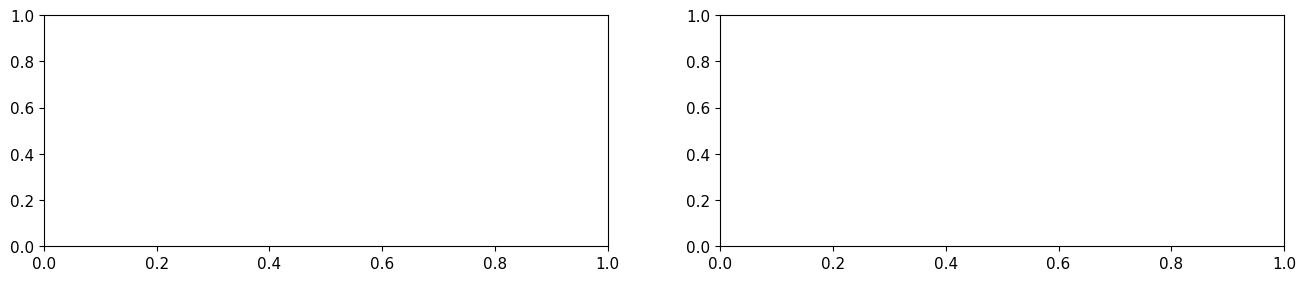

In [7]:
# Parâmetros para simulação
Sps = 16  # Amostras por símbolo
M = 4              # Ordem do formato de modulação
Rs = 10e9          # taxa de símbolos
Fs = Sps*Rs        # taxa de amostragem
Ts = 1/Fs

#Potência do laser na entrada do modulador Mach-Zehnder em dbm e W
Pi_dbm = 0
Pi_W = dBm2W(Pi_dbm)

#Parâmetros do Mach-Zehnder
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

#Sequência de bits aleatórios
bitsTx = np.random.randint(2, size = int(np.log2(M)*1e6))
print("Formato do array de bits: ", bitsTx.shape)

#Sequência de símbolos modulados em OOK
symbTx = modulateGray(bitsTx, M, 'pam')    
symbTx = pnorm(symbTx) # normaliza a potência
print("Formato do array dos bits modulados em PAM: ", symbTx.shape)

#upsampling
symbUp = upsample(symbTx, Sps)
print("Formato do array depois do upsampling ", symbUp.shape)

#Pulso NRZ
pulse = pulseShape('nrz', Sps)
pulse = pulse/max(abs(pulse))

#Formatação de pulso
sigTx = firFilter(pulse, symbUp)
print("Formato do array depois da formataç~~ao de pulso: ", sigTx.shape)

#Modulação óptica
Ai = np.sqrt(Pi_W)
sigTxo = mzm(Ai, 0.5*sigTx, paramMZM)

print('Potência média do sinal ótpico modulado [mW]: %.3f mW'%(signal_power(sigTxo)/1e-3))
print('Potência média do sinal óptico modualdo [dBm: %.3f dBm]'%(10*np.log10(signal_power(sigTxo)/1e-3)))
print('Quantidade de bits: ', len(bitsTx))
fig, axs = plt.subplots(1, 2, figsize=(16,3))
interval = np.arange(16*20,16*50)
t = interval*Ts/1e-9
'''
#Plot da PSD
axs[0].set_xlim(-3*Rs, 3*Rs);
axs[0].set_ylim(-180, -80);
axs[0].psd(sigTx, Fs = Fs, NFFT = 16*1024, sides = 'twosided', label = 'Espectro do sinal RF')
axs[0]. legend(loc = 'upper left');

axs[1].plot(t, sigTx[interval], label = 'Sinal binário RF', linewidth = 2)
axs[1].set_ylabel('Amplitude (a.u.)')
axs[1].set_xlabel('Tempo (ns)')
axs[1].set_xlim(min(t),max(t))
axs[1].legend(loc='upper left')
axs[1].grid()

fig, axs = plt.subplots(1, 2, figsize=(16,3))
# plot psd
axs[0].set_xlim(-3*Rs,3*Rs);
axs[0].set_ylim(-255,-155);
axs[0].psd(np.abs(sigTxo)**2, Fs=Fs, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal óptico')
axs[0].legend(loc='upper left');

axs[1].plot(t, np.abs(sigTxo[interval])**2, label = 'Sinal modulado óptico', linewidth=2)
axs[1].set_ylabel('Potência (p.u.)')
axs[1].set_xlabel('Tempo (ns)')
axs[1].set_xlim(min(t),max(t))
axs[1].legend(loc='upper left')
axs[1].grid()'''

In [8]:
#eyediagram(sigTx[discard:-discard], sigTx.size-2*discard, Sps, plotlabel='signal at Tx', ptype='fancy')

In [9]:
# Canal óptico linear
paramCh = parameters()
paramCh.L = 100         # Distância [km]
paramCh.α = 0.2        # Parâmetro de perdas da fibra [dB/km]
paramCh.D = 16         # Parâmetro de dispersão da fibra [ps/nm/km]
paramCh.Fc = 193.1e12  # Frequência óptica central [Hz]
paramCh.Fs = Fs        # Frequência de amostragem da simulação [samples/second]

sigCh = linearFiberChannel(sigTxo, paramCh)

# Pré-amplificador do receptor
paramEDFA = parameters()
paramEDFA.G = paramCh.α*paramCh.L    # ganho edfa
paramEDFA.NF = 4.6   # edfa noise figure 
paramEDFA.Fc = paramCh.Fc
paramEDFA.Fs = Fs

sigCh = edfa(sigCh, paramEDFA)

In [10]:
# fotodiodo ideal (sem ruído e limitação de banda)
paramPD = parameters()
paramPD.ideal = True
paramPD.Fs = Fs
I_Rx_ideal = photodiode(sigTxo.real, paramPD)

# noisy photodiode (ruídos térmico e de disparo + limitação de banda)
paramPD = parameters()
paramPD.ideal = False
paramPD.B = Rs
paramPD.Fs = Fs

I_Rx = photodiode(sigCh, paramPD)
print("Formato do array no final do canal", I_Rx.shape)
discard = 100



Formato do array no final do canal (16000000,)


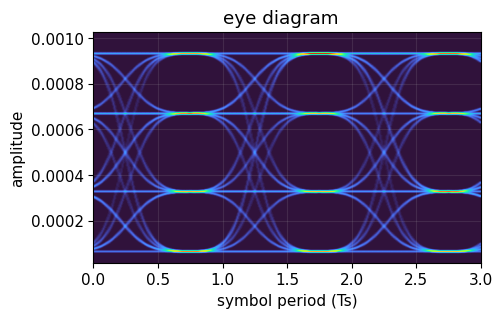

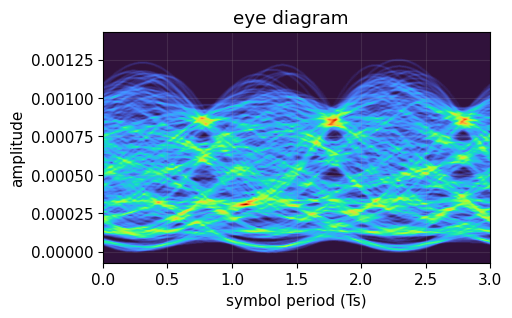

In [33]:
eyediagram(I_Rx_ideal[discard:-discard], I_Rx.size-2*discard, Sps, ptype='fancy')
eyediagram(I_Rx[discard:-discard], I_Rx.size-2*discard, Sps, ptype='fancy')

Number of counted errors = 33144 
BER = 1.66e-02 


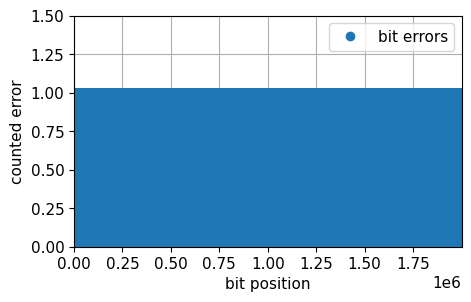

In [11]:
#Recupera os bits do sinal

bitsr1 = RecuperaBits(sinal = I_Rx, SpS = Sps, M = M)
bitst1 = RecuperaBits(sinal = sigTx, SpS = Sps, M = M)

#Calcula a taxa de erro entre os bits

CalculaBER(bitst1, bitsr1)

# Segunda Simulação, para Teste da Rede Neural

In [12]:
#Parâmetros do Sinal
SpS2 = 16  # Amostras por símbolo
M2 = 4              # Ordem do formato de modulação
Rs2 = 10e9          # taxa de símbolos

#Simulação do Sinal
sinalt, symbt = SimulaSinalOptico(SpS = SpS2, M = M2, Rs = Rs2)



In [13]:
#Parâmetros do Canal
dist_fibra = 100
ruido = 4.5

sinalr = SimulaCanalOptico(sinal = sinalt, Rs = Rs2, SpS = SpS2,  dist_fibra = dist_fibra, ruido = ruido)

discard = 100


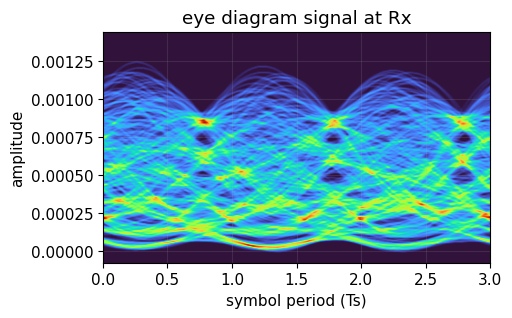

In [31]:
eyediagram(sinalr[discard:-discard], sinalr.size-2*discard, SpS2, plotlabel='signal at Rx', ptype='fancy')

Number of counted errors = 32897 
BER = 1.65e-02 


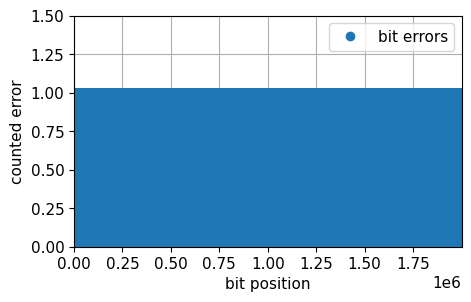

In [14]:
#Recupera os bits do sinal

bitsr2 = RecuperaBits(sinal = sinalr, SpS = SpS2, M = M2)
bitst2 = RecuperaBits(sinal = sinalt, SpS = SpS2, M = M2)
#Calcula a taxa de erro entre os bits

CalculaBER(bitst2, bitsr2)

# Criando um Conjunto de Dados para Alimentar a Rede Neural

In [15]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from optic.torchUtils import slidingWindowDataSet, MLP

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'



In [16]:
# Define o número de taps e de amostras por símbolo
Ntaps = 64
SpS_in = 16
SpS_out = 1
Nsymbols_train = len(symbTx)
Nsymbols_test = len(symbt)

batch_size = 64
shuffle = False

# Pré-processamento dos dados

#Dados de treino e acompanhamento do progresso (1ª Simulação)
signal_train_full = pnorm(I_Rx[0::SpS_in//SpS_out])   #Recupera o sinal nos intervalos de sinalização
signal_train = pnorm(I_Rx[0:Nsymbols_train*SpS_in:SpS_in//SpS_out])
symbols_train = pnorm(symbTx[0:Nsymbols_train])   #Símbolos a serem passados como alvo do equalizador

signal_train = (signal_train - np.mean(signal_train))/np.std(signal_train)
signal_train_full = (signal_train_full - np.mean(signal_train_full))/np.std(signal_train_full)
symbols_train = (symbols_train - np.mean(symbols_train))/np.std(symbols_train)

#Dados de Teste (2ª Simulação)
signal_test_full = pnorm(sinalr[0::SpS_in//SpS_out])   
signal_test = pnorm(sinalr[0:Nsymbols_test*SpS_in:SpS_in//SpS_out])
symbols_test = pnorm(symbt[0:Nsymbols_test])

signal_test = (signal_test - np.mean(signal_test))/np.std(signal_test)
signal_test_full = (signal_test_full - np.mean(signal_test_full))/np.std(signal_test_full)
symbols_test = (symbols_test - np.mean(symbols_test))/np.std(symbols_test)

symbols_train = symbols_train.reshape(-1,1)
symbols_test = symbols_test.reshape(-1, 1)


#Criação dos Datasets

idxtrain = np.arange(0, int(0.8 * len(symbols_train)))
idxprogress = np.arange(int(0.8 * len(symbols_train)), len(symbols_train))

sig_train = signal_train[idxtrain] #80% para treinamento
sig_progress = signal_train[idxprogress]   #20% para avaliação do progresso
sig_test = signal_test_full        #100% para teste


train_dataset = slidingWindowDataSet(sig_train, symbols_train[idxtrain], Ntaps, SpS_out)
progress_dataset = slidingWindowDataSet(sig_progress, symbols_train[idxprogress], Ntaps, SpS_out)
test_dataset1 = slidingWindowDataSet(signal_train, symbols_train, Ntaps, SpS_out)
test_dataset2 = slidingWindowDataSet(signal_test_full, symbols_test, Ntaps, SpS_out)

#Criação dos Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
progress_dataloader = DataLoader(progress_dataset, batch_size=batch_size, shuffle=shuffle)
test_dataloader1 = DataLoader(test_dataset1, batch_size=batch_size, shuffle=shuffle)
test_dataloader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=shuffle)
dataloader_full = DataLoader(test_dataset2, batch_size = len(test_dataset2), shuffle = shuffle)


In [17]:
print(signal_test.shape)
print(signal_test_full.shape)

(1000000,)
(1000000,)


# Criação de uma rede neural para equalização

In [18]:
#Cria uma rede neural com quatro camadas e usa ReLU como camada oculta entre elas
equalizer = MLP([Ntaps, 32, 16, 8, 4, 1])

# Treinamento da rede com dados da simulação

In [19]:
#Definição dos hiperparâmetros
loss = nn.MSELoss()
optimizer = torch.optim.Adam(equalizer.parameters(), lr = 0.0006)
epochs = 4
cada_print = 10000

In [20]:
#Definição dos loops de treino e avaliação
def train_loop(train_dataloader, equalizer, loss, optimizer, cada_print):
    size = len(train_dataloader.dataset)
    
    equalizer.train()
    for batch, (x, y) in enumerate(train_dataloader):
        x, y = x.float(), y.float()
        predict = equalizer(x)
        loss_value = loss(predict, y)
        
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % cada_print == 0:
            loss_value, current = loss_value.item(), (batch+1)*len(x)
            print(f"loss: {loss_value:>7f}[{current:>5d}/{size:>5d}]" )

def test_loop(progress_dataloader, equalizer, loss):
    size = len(progress_dataloader.dataset)
    num_batches = len(progress_dataloader)
    equalizer.eval()
    eval_loss = 0
    with torch.no_grad():
        for x, y in progress_dataloader:
            x, y = x.float(), y.float()
            pred = equalizer(x)
            eval_loss += loss(pred, y).item()
    eval_loss /= num_batches
    print(f"Perda média: {eval_loss:>8f} \n")

In [22]:
for t in range(epochs):
    print(f"Época {t+1}\n-------------------------------")
    train_loop(train_dataloader, equalizer, loss, optimizer, cada_print)
    test_loop(progress_dataloader, equalizer, loss)
print("Pronto!")

Época 1
-------------------------------
loss: 1.175738[   64/800000]
loss: 0.002669[640064/800000]
Perda média: 0.002002 

Época 2
-------------------------------
loss: 0.013951[   64/800000]
loss: 0.000628[640064/800000]
Perda média: 0.000711 

Época 3
-------------------------------
loss: 0.013134[   64/800000]
loss: 0.000058[640064/800000]
Perda média: 0.000160 

Época 4
-------------------------------
loss: 0.012622[   64/800000]
loss: 0.000016[640064/800000]
Perda média: 0.000063 

Pronto!


In [23]:
#Salva o modelo e seus parâmetros
#torch.save(equalizer, 'Equalizer5LayerReLU.pth')

In [24]:
test_loop(test_dataloader2, equalizer, loss)
test_loop(test_dataloader1, equalizer, loss)

Perda média: 0.000069 

Perda média: 0.000064 



In [25]:
    equalizer.eval()
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader_full):
            X = X.float()
            pred = equalizer(X)
            symbRx_NN = pred

            symbRx_NN = symbRx_NN.numpy().reshape(-1,)

            break

(1000000,)
(1000000,)
(2000000,)
(2000000,)
Number of counted errors = 62 
BER = 3.10e-05 


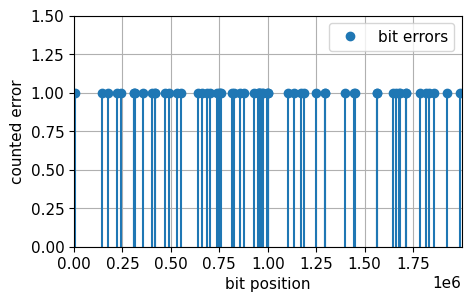

In [26]:
const = GrayMapping(M, 'pam') 
Es = signal_power(const)
bitsRx_NN = demodulateGray(np.sqrt(Es)*pnorm(symbRx_NN), M, 'pam')
bitt = demodulateGray(np.sqrt(Es)*pnorm(symbt), M, 'pam')
print(symbRx_NN.shape)
print(symbt.shape)
print(bitsRx_NN.shape)
print(bitt.shape)
CalculaBER(bitst2, bitsRx_NN)

# Avaliação da rede com uma fibra de 100 km

In [27]:
discard = 100
power = np.arange(-15, 0)
BER = np.zeros(power.size)
BER_NN = np.zeros(power.size)
SpS_out = 1
Ntaps = 64

for ind, Pin in enumerate(power):
    sinaltx70, symbtx70 = SimulaSinalOptico(SpS = SpS2, Rs = Rs2, M = M2, Pi_dBm = Pin)
    
    irx70 = SimulaCanalOptico(sinaltx70, SpS = SpS2, Rs = Rs2, dist_fibra = 100)
    
    bitsTx70 = RecuperaBits(sinaltx70, SpS2, M2)
    bitsRx70 = RecuperaBits(irx70, SpS2, M2)
    
    err = np.logical_xor(bitsRx70[discard:bitsRx70.size-discard], bitsTx70[discard:bitsTx70.size-discard])
    BER[ind] = np.mean(err)
    
    print('BER = %.2e '%(BER[ind]))
    
    signalrx = pnorm(irx70[0::SpS_in//SpS_out])
    signalrx= (signalrx - np.mean(signalrx))/np.std(signalrx)
    
    dataset = slidingWindowDataSet(signalrx, symbtx70, Ntaps, SpS_out)
    
    dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

    equalizer.eval()
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X = X.float()
            pred = equalizer(X)
            symbRx_NN = pred
            symbRx_NN = symbRx_NN.numpy().reshape(-1,)
    
    bitsRx_NN = demodulateGray(np.sqrt(Es)*pnorm(symbRx_NN), M2, 'pam')

    #discard = 1000
    err = np.logical_xor(bitsRx_NN[discard:bitsRx_NN.size-discard], bitsTx70[discard:bitsTx70.size-discard])
    BER_NN[ind] = np.mean(err)

    #Pb = 0.5*erfc(Q/np.sqrt(2)) # theoretical error probability
    print('BER_NN = %.2e '%(BER_NN[ind]))

BER = 1.55e-01 
BER_NN = 1.48e-01 
BER = 1.33e-01 
BER_NN = 1.21e-01 
BER = 1.12e-01 
BER_NN = 9.51e-02 
BER = 9.45e-02 
BER_NN = 7.31e-02 
BER = 7.93e-02 
BER_NN = 5.35e-02 
BER = 6.57e-02 
BER_NN = 3.73e-02 
BER = 5.49e-02 
BER_NN = 2.51e-02 
BER = 4.55e-02 
BER_NN = 1.59e-02 
BER = 3.79e-02 
BER_NN = 9.71e-03 
BER = 3.22e-02 
BER_NN = 5.50e-03 
BER = 2.76e-02 
BER_NN = 2.82e-03 
BER = 2.41e-02 
BER_NN = 1.41e-03 
BER = 2.12e-02 
BER_NN = 5.96e-04 
BER = 1.92e-02 
BER_NN = 2.57e-04 
BER = 1.78e-02 
BER_NN = 1.09e-04 


Text(0, 0.5, 'log10(BER)')

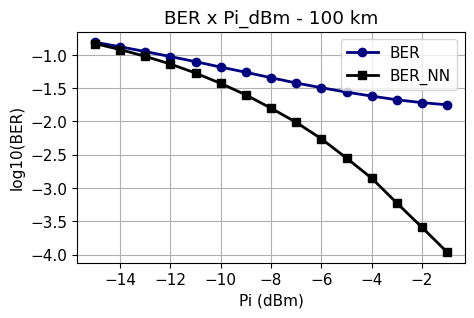

In [28]:
plt.plot(power, np.log10(BER),'-o', label='BER',linewidth = 2, color = 'navy')
plt.plot(power, np.log10(BER_NN),'-s', label='BER_NN', color = 'black', linewidth = 2)
plt.grid()
plt.legend();
plt.title('BER x Pi_dBm - 100 km')
plt.xlabel('Pi (dBm)')
plt.ylabel('log10(BER)')

# Avaliação da mesma rede para um canal de 80 km

In [29]:
discard = 100
power = np.arange(-15, 0)
BER = np.zeros(power.size)
BER_NN = np.zeros(power.size)
SpS_out = 1
Ntaps = 64

for ind, Pin in enumerate(power):
    sinaltx70, symbtx70 = SimulaSinalOptico(SpS = SpS2, Rs = Rs2, M = M2, Pi_dBm = Pin)
    
    irx70 = SimulaCanalOptico(sinaltx70, SpS = SpS2, Rs = Rs2, dist_fibra = 80)
    
    bitsTx70 = RecuperaBits(sinaltx70, SpS2, M2)
    bitsRx70 = RecuperaBits(irx70, SpS2, M2)
    
    err = np.logical_xor(bitsRx70[discard:bitsRx70.size-discard], bitsTx70[discard:bitsTx70.size-discard])
    BER[ind] = np.mean(err)
    
    print('BER = %.2e '%(BER[ind]))
    
    signalrx = pnorm(irx70[0::SpS_in//SpS_out])
    signalrx= (signalrx - np.mean(signalrx))/np.std(signalrx)
    
    dataset = slidingWindowDataSet(signalrx, symbtx70, Ntaps, SpS_out)
    
    dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

    equalizer.eval()
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X = X.float()
            pred = equalizer(X)
            symbRx_NN = pred
            symbRx_NN = symbRx_NN.numpy().reshape(-1,)
    
    bitsRx_NN = demodulateGray(np.sqrt(Es)*pnorm(symbRx_NN), M2, 'pam')

    #discard = 1000
    err = np.logical_xor(bitsRx_NN[discard:bitsRx_NN.size-discard], bitsTx70[discard:bitsTx70.size-discard])
    BER_NN[ind] = np.mean(err)

    #Pb = 0.5*erfc(Q/np.sqrt(2)) # theoretical error probability
    print('BER_NN = %.2e '%(BER_NN[ind]))

BER = 7.11e-02 
BER_NN = 7.41e-02 
BER = 5.02e-02 
BER_NN = 5.25e-02 
BER = 3.32e-02 
BER_NN = 3.57e-02 
BER = 2.11e-02 
BER_NN = 2.37e-02 
BER = 1.29e-02 
BER_NN = 1.56e-02 
BER = 7.48e-03 
BER_NN = 9.99e-03 
BER = 4.41e-03 
BER_NN = 6.51e-03 
BER = 2.45e-03 
BER_NN = 4.21e-03 
BER = 1.40e-03 
BER_NN = 2.63e-03 
BER = 8.80e-04 
BER_NN = 1.78e-03 
BER = 5.00e-04 
BER_NN = 1.11e-03 
BER = 3.61e-04 
BER_NN = 7.24e-04 
BER = 2.42e-04 
BER_NN = 4.59e-04 
BER = 1.52e-04 
BER_NN = 2.75e-04 
BER = 1.07e-04 
BER_NN = 2.03e-04 


Text(0, 0.5, 'log10(BER)')

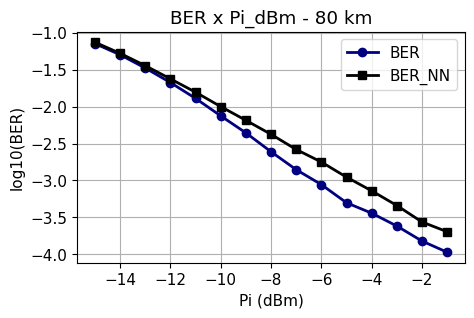

In [30]:
plt.plot(power, np.log10(BER),'-o', label='BER',linewidth = 2, color = 'navy')
plt.plot(power, np.log10(BER_NN),'-s', label='BER_NN', color = 'black', linewidth = 2)
plt.grid()
plt.legend();
plt.title('BER x Pi_dBm - 80 km')
plt.xlabel('Pi (dBm)')
plt.ylabel('log10(BER)')